## Seattle Terry Stops Modeling


Alright this is the third part of the project. For a brief recap, we started with the preprocessing part where we loaded the Terry Stops csv data that we downloaded from the Seattle City official website. At this stage we observed, cleaned and preprocessed the data. We created a csv file with the cleaned data to be used for EDA. At the second part we used the cleaned data to do our exploratory analysis. We addressed a couple of problems and came up with recommendations we believe are going to resolve those problems.
At this third part we are going to focus on modeling. The sole purpose of this stage is to:
* creating the best model that predicts the likelihood of an arrest during a Terry Stop

Tha said let us get started.

## Loading the data

In [28]:
# Importing the relevant modules and libraries first
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, \
accuracy_score, recall_score, precision_score, f1_score, log_loss, roc_auc_score, roc_curve
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

In [29]:
# Loading the data
df = pd.read_csv('data/clean_Terry_stops_data.csv')

df.head()

,subject_age_group,subject_id,go_sc_num,terry_stop_id,stop_resolution,weapon_type,officer_id,officer_gender,officer_race,subject_perceived_race,...,beat,repeat_offenders,incident_year,incident_month,officer_age,field_contact,offense_report,reported_hour,same_race,same_gender
0,36_45,unassigned,20160000398323,208373,Offense Report,NaN,4852,M,Asian,White,...,L3,No,2016,11,63,N,Y,15,N,Y
1,18_25,unassigned,20180000227180,559146,Citation / Infraction,NaN,5472,M,Asian,Hispanic,...,F3,No,2018,6,54,N,N,0,N,Y
2,18_25,unassigned,20180000410091,498246,Offense Report,NaN,6081,M,White,White,...,B1,No,2018,11,56,N,Y,2,Y,Y
3,Unknown,unassigned,20160000001637,146742,Field Contact,NaN,6924,M,White,Not Specified,...,C1,No,2016,4,42,Y,N,1,N,N
4,46_55,unassigned,20150000006037,104477,Field Contact,NaN,6732,M,White,White,...,B2,No,2015,11,40,Y,N,2,Y,N


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60252 entries, 0 to 60251
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   subject_age_group         60252 non-null  object
 1   subject_id                60252 non-null  object
 2   go_sc_num                 60252 non-null  int64 
 3   terry_stop_id             60252 non-null  int64 
 4   stop_resolution           60252 non-null  object
 5   weapon_type               28157 non-null  object
 6   officer_id                60252 non-null  int64 
 7   officer_gender            60252 non-null  object
 8   officer_race              60252 non-null  object
 9   subject_perceived_race    60252 non-null  object
 10  subject_perceived_gender  60252 non-null  object
 11  initial_call_type         60252 non-null  object
 12  final_call_type           60252 non-null  object
 13  call_type                 60252 non-null  object
 14  arrest_flag           

Ok so for this part we do not need all the columns so we will drop all the columns we are not going to use and keep only the necessary ones.


In [31]:
# Creating a column that gets the arrest values
df['arrested'] = df['arrest_flag'].apply(lambda x: 'Y' if x == 'Y' else 'N')
df.head()

,subject_age_group,subject_id,go_sc_num,terry_stop_id,stop_resolution,weapon_type,officer_id,officer_gender,officer_race,subject_perceived_race,...,repeat_offenders,incident_year,incident_month,officer_age,field_contact,offense_report,reported_hour,same_race,same_gender,arrested
0,36_45,unassigned,20160000398323,208373,Offense Report,NaN,4852,M,Asian,White,...,No,2016,11,63,N,Y,15,N,Y,N
1,18_25,unassigned,20180000227180,559146,Citation / Infraction,NaN,5472,M,Asian,Hispanic,...,No,2018,6,54,N,N,0,N,Y,N
2,18_25,unassigned,20180000410091,498246,Offense Report,NaN,6081,M,White,White,...,No,2018,11,56,N,Y,2,Y,Y,N
3,Unknown,unassigned,20160000001637,146742,Field Contact,NaN,6924,M,White,Not Specified,...,No,2016,4,42,Y,N,1,N,N,N
4,46_55,unassigned,20150000006037,104477,Field Contact,NaN,6732,M,White,White,...,No,2015,11,40,Y,N,2,Y,N,N


The arrested column is our target. In this model we are going to see which model can predict the out come of our target more accurately.

In [32]:
# Creating a list of columns to drop
col_to_drop = ['subject_id', 'go_sc_num', 'terry_stop_id', 'stop_resolution', 'officer_id', 'officer_race', 
               'arrest_flag', 'sector', 'beat', 'repeat_offenders', 'incident_month']

# Dropping the columns and creating a new DataFrame
df_copy = df.drop(columns=col_to_drop, axis=1)


# Checking the dataframe
df_copy.head()

,subject_age_group,weapon_type,officer_gender,subject_perceived_race,subject_perceived_gender,initial_call_type,final_call_type,call_type,frisk_flag,precinct,incident_year,officer_age,field_contact,offense_report,reported_hour,same_race,same_gender,arrested
0,36_45,NaN,M,White,M,TRESPASS,--SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,911,N,North,2016,63,N,Y,15,N,Y,N
1,18_25,NaN,M,Hispanic,M,"SUSPICIOUS PERSON, VEHICLE, OR INCIDENT",--TRAFFIC - BICYCLE VIOLATION,911,N,Southwest,2018,54,N,N,0,N,Y,N
2,18_25,NaN,M,White,M,"NARCOTICS - VIOLATIONS (LOITER, USE, SELL, NARS)",--SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,911,N,North,2018,56,N,Y,2,Y,Y,N
3,Unknown,NaN,M,Not Specified,Unable to Determine,Unknown,Unknown,Unknown,N,East,2016,42,Y,N,1,N,N,N
4,46_55,NaN,M,White,F,Unknown,Unknown,Unknown,N,North,2015,40,Y,N,2,Y,N,N


In [33]:
# Identifying our features and target
X = df_copy.drop('arrested', axis=1)
y = df_copy['arrested']


In [34]:
import itertools
# Define a function to plot a confusion matrix:
def confusion_matrix_plot(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    # Function to create a confusion matrix chart for model performance visualization
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
    plt.colorbar()
    plt.show()

In [35]:
# Define class names for Arrested (1) and Not Arrested (0):
class_names = ['Arrested', 'Not Arrested']

## One Hot Encoding
As we can see it a lot of our data is non-numerical. So we will need to OneHotEncode our features to be able to use them.


In [36]:

# One Hot Encoding our train and test data
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

# Initialize OneHotEncoder
ohe = OneHotEncoder(sparse_output=False, drop='first')  # Drop first to avoid dummy variable trap

# Fit and transform categorical features
X_encoded = ohe.fit_transform(X[categorical_features])

# Convert encoded features to DataFrame
X_encoded_df = pd.DataFrame(X_encoded, columns=ohe.get_feature_names_out(categorical_features))

# Combine encoded features with numerical features
X_final = pd.concat([X[numerical_features], X_encoded_df], axis=1)

In [37]:
# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the combined features
X_scaled = scaler.fit_transform(X_final)

# Convert scaled features to DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X_final.columns)

X_scaled_df.head()

,incident_year,officer_age,reported_hour,subject_age_group_1_17,subject_age_group_26_35,subject_age_group_36_45,subject_age_group_46_55,subject_age_group_56_up,subject_age_group_Unknown,weapon_type_Firearm,...,frisk_flag_Y,precinct_North,precinct_South,precinct_Southwest,precinct_Unknown,precinct_West,field_contact_Y,offense_report_Y,same_race_Y,same_gender_Y
0,-1.048799,3.455408,0.451194,-0.197547,-0.709194,1.863256,-0.381384,-0.236401,-0.189938,-0.107395,...,-0.561811,1.935683,-0.371007,-0.289963,-0.466799,-0.61813,-0.968851,1.695135,-0.785455,0.612876
1,-0.275143,2.365502,-1.621914,-0.197547,-0.709194,-0.536695,-0.381384,-0.236401,-0.189938,-0.107395,...,-0.561811,-0.516614,-0.371007,3.448716,-0.466799,-0.61813,-0.968851,-0.589924,-0.785455,0.612876
2,-0.275143,2.607703,-1.345500,-0.197547,-0.709194,-0.536695,-0.381384,-0.236401,-0.189938,-0.107395,...,-0.561811,1.935683,-0.371007,-0.289963,-0.466799,-0.61813,-0.968851,1.695135,1.273148,0.612876
3,-1.048799,0.912293,-1.483707,-0.197547,-0.709194,-0.536695,-0.381384,-0.236401,5.264863,-0.107395,...,-0.561811,-0.516614,-0.371007,-0.289963,-0.466799,-0.61813,1.032150,-0.589924,-0.785455,-1.631653
4,-1.435627,0.670092,-1.345500,-0.197547,-0.709194,-0.536695,2.622031,-0.236401,-0.189938,-0.107395,...,-0.561811,1.935683,-0.371007,-0.289963,-0.466799,-0.61813,1.032150,-0.589924,1.273148,-1.631653


## Logistic Regression Model
We are going to use logistic regression fro our baseline model.

In [38]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42)

# Creating a logistic regression model
lr_model = LogisticRegression(max_iter=1000)

# Training our model
lr_model.fit(X_train, y_train)

# Evaluating the model's performance
y_hat_test = lr_model.predict(X_test)
print("Logistic Regression Model")
print(classification_report(y_hat_test, y_test))

Logistic Regression Model
              precision    recall  f1-score   support

           N       1.00      1.00      1.00     10724
           Y       0.99      0.98      0.99      1327

    accuracy                           1.00     12051
   macro avg       0.99      0.99      0.99     12051
weighted avg       1.00      1.00      1.00     12051



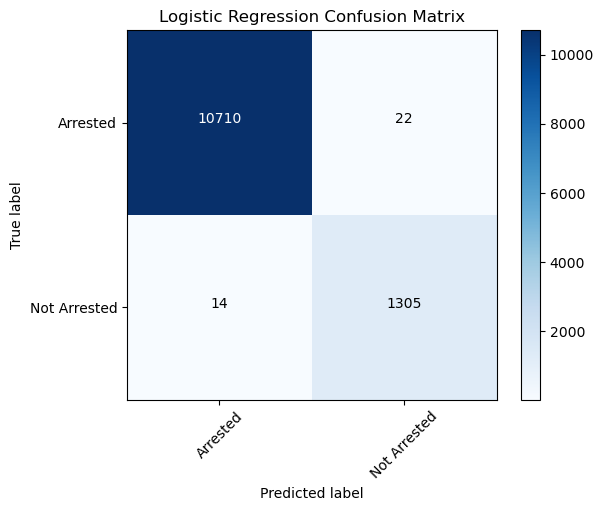

In [39]:
# Calling the confusion matrix function we prepared above
cm_logreg = confusion_matrix(y_test, y_hat_test)

# Plot the confusion matrix:
confusion_matrix_plot(cm_logreg, classes=class_names, title='Logistic Regression Confusion Matrix')

The model seems to be doing really good but we shouldn't be fooled with the high scores. Let us try some other models and see what we can get out of them.

## K-Nearest-Neighbors (KNN) Classifier

In [40]:
# Determine the optimal k value for KNN classification:

def find_best_k(X_train, y_train, X_test, y_test, min_k=1, max_k=25):
    best_k = 0
    best_score = 0.0
    for k in range(min_k, max_k + 1, 2):
        knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
        knn.fit(X_train, y_train)
        preds = knn.predict(X_test)
        accuracy = accuracy_score(y_test, preds)
        if accuracy > best_score:
            best_k = k
            best_score = accuracy
    
    print("Best Value for k: {}".format(best_k))
    print("Accuracy Score: {:.4f}".format(best_score))

In [41]:
# Call the function to find the best k value:
find_best_k(X_train, y_train, X_test, y_test)

Best Value for k: 9
Accuracy Score: 0.9223


KNN Classification
Build and evaluate the KNN model using the optimal k value:

In [42]:
# Create the KNN classifier with the best k value:
knn = KNeighborsClassifier(n_neighbors=25, algorithm='brute')
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

In [43]:
# Evaluating
print('Classification Report:')
print(classification_report(y_test, y_pred_knn))

Classification Report:
              precision    recall  f1-score   support

           N       0.92      0.99      0.96     10732
           Y       0.79      0.34      0.47      1319

    accuracy                           0.92     12051
   macro avg       0.86      0.66      0.71     12051
weighted avg       0.91      0.92      0.90     12051



## Confusion Matrix for KNN
Visualize the performance of the KNN model using a confusion matrix:

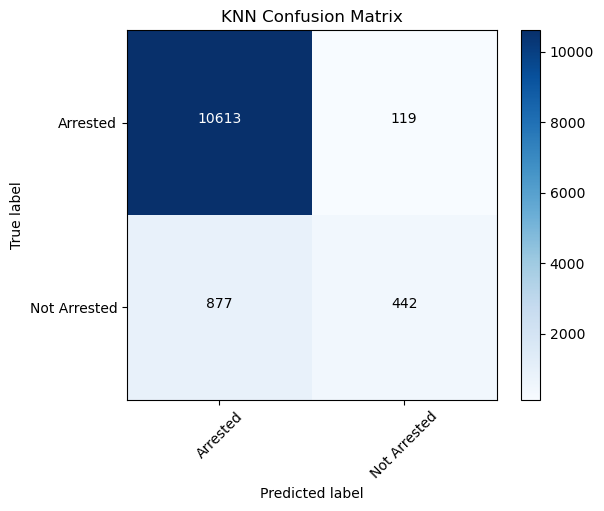

In [44]:
# Create the confusion matrix for KNN:
cm_knn = confusion_matrix(y_test, y_pred_knn)

# Plot the confusion matrix:
confusion_matrix_plot(cm_knn, classes=class_names, title='KNN Confusion Matrix')

## Decision Trees
Let's explore decision trees.

### Grid Search for Optimal Parameters
We'll begin by running a grid search to identify the optimal parameters for our decision tree model:

In [45]:
# Instantiating a baseline classifier:
dtree = DecisionTreeClassifier(random_state=42)

# Creating a parameter grid for grid search:
param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": range(1, 10),
    "min_samples_split": range(2, 10)
}

# Performing grid search to find the best parameters:
gs_tree = GridSearchCV(dtree, param_grid, cv=5, n_jobs=-1)
gs_tree.fit(X_train, y_train)

# Printing the best estimator parameters:
print(gs_tree.best_params_)

{'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 2}


## Decision Tree Classification
Now, we'll use the best parameters identified from grid search to build and evaluate our decision tree model:

In [46]:
# Creating the decision tree classifier with best parameters:
d_tree = DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_split=2)
d_tree.fit(X_train, y_train)
y_pred_dtree = d_tree.predict(X_test)

# Checking the accuracy of the decision tree model:
accuracy_dtree = accuracy_score(y_test, y_pred_dtree)
print('Decision Tree Accuracy: {:.2f}%'.format(accuracy_dtree * 100))

Decision Tree Accuracy: 99.80%


In [47]:
# Printing the classification report:
print(classification_report(y_test, y_pred_dtree))

              precision    recall  f1-score   support

           N       1.00      1.00      1.00     10732
           Y       0.98      1.00      0.99      1319

    accuracy                           1.00     12051
   macro avg       0.99      1.00      0.99     12051
weighted avg       1.00      1.00      1.00     12051



## Confusion Matrix for Decision Tree
Visualize the performance of the decision tree using a confusion matrix:

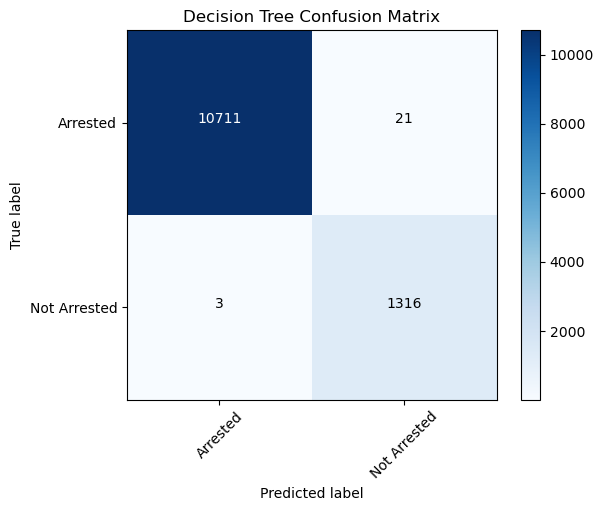

In [48]:
# Creating the confusion matrix for decision tree:
cm_dtree = confusion_matrix(y_test, y_pred_dtree)

# Plotting the confusion matrix:
confusion_matrix_plot(cm_dtree, classes=class_names, title='Decision Tree Confusion Matrix')

## Identifying the BEST MODEL
Ok we are at the final stage of our project. Here we are defining a function called evaluate_models() which takes our feature and target variables with 20% test size and random state of 42. The function returns the best model based on the highest F1 score. The reason we decided to use the F1 score as the final weighing parameter is because we have class imbalance.

In [50]:

# Defining the function
def evaluate_models(X, y, test_size=0.2, random_state=42):
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Initialize models
    models = {
        'Logistic Regression': LogisticRegression(),
        'K-Nearest Neighbors': KNeighborsClassifier(),
        'Decision Tree': DecisionTreeClassifier()
    }
    
    # Dictionary to store classification reports
    reports = {}
    f1_scores = {}
    
    # Train and evaluate each model
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True)
        reports[name] = report
        f1_scores[name] = report['macro avg']['f1-score']
    
    # Identify the best model based on the highest F1 score
    best_model = max(f1_scores, key=f1_scores.get)
    
    # Output classification reports
    for name, report in reports.items():
        print(f"Classification Report for {name}:\n")
        print(classification_report(y_test, models[name].predict(X_test)))
    
    print(f"\nBest Model: {best_model} with F1 score of {f1_scores[best_model]}")

    return best_model

# Example usage:
# X and y should be your features and target variables
best_model = evaluate_models(X_scaled_df, y)

Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           N       1.00      1.00      1.00     10732
           Y       0.98      0.99      0.99      1319

    accuracy                           1.00     12051
   macro avg       0.99      0.99      0.99     12051
weighted avg       1.00      1.00      1.00     12051

Classification Report for K-Nearest Neighbors:

              precision    recall  f1-score   support

           N       0.94      0.97      0.96     10732
           Y       0.68      0.51      0.58      1319

    accuracy                           0.92     12051
   macro avg       0.81      0.74      0.77     12051
weighted avg       0.91      0.92      0.91     12051

Classification Report for Decision Tree:

              precision    recall  f1-score   support

           N       1.00      1.00      1.00     10732
           Y       0.99      0.99      0.99      1319

    accuracy                           1.00 

## Conclusion: 
The Logistic Regression, KNN and Decision Tree models were used in this task of identifying the best performing model in accurately predicting the likelihood of an arrest occuring during a terry stop in Seattle. To perform the task we selected specific features;

* 'subject_age_group', 'weapon_type', 'officer_gender', 'subject_perceived_race', 'subject_perceived_gender', 'initial_call_type', 'final_call_type', 'call_type', 'frisk_flag', 'precinct', 'incident_year', 'officer_age', 'field_contact', 'offense_report', 'reported_hour', 'same_race', 'same_gender', 'arrested'

Our target variable was the 'arrested' column which we created based on the 'arrest_flag' feature. 

Remarkably the Logistic Regression and the Decision Tree models did really well in predicting the outcomes of Terry stops, showcasing their potential for aiding law enforcement decision-making processes. Based on the outcome of the function we defined to identify the best model though we are concluding that the Decision Tree Model is the best performing one to be recommended.

Further exploration, including fine-tuning hyperparameters and evaluating additional metrics, can contribute to a comprehensive understanding of their effectiveness in real-world scenarios.